# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [2]:
df = pd.read_csv('../data/checker_submits.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['uid', 'labname', 'hour']])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(['uid', 'labname', 'hour']))
df = pd.concat([df, encoded_df], axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['numTrials']])
df[['numTrials']] = scaled_features

df.drop(['uid', 'labname', 'timestamp', 'hour'], axis=1, inplace=True)

df.to_csv('../data/dayofweek.csv', index=False)
df.head()

,numTrials,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,uid_user_15,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,-0.788667,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.756764,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.724861,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.692958,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.661055,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
popular_day = df['dayofweek'].mode()[0]
naive_accuracy = (df['dayofweek'] == popular_day).mean()
print(f"Naive algorithm accuracy: {naive_accuracy:.4f}")

Naive algorithm accuracy: 0.2349


## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [4]:
X = df.drop(columns='dayofweek')
y = df['dayofweek']

model = LogisticRegression(fit_intercept=False, random_state=21)
model.fit(X, y)

accuracy = accuracy_score(y, model.predict(X))
print(f'Accuracy : {accuracy:.4f}')

Accuracy : 0.7070


In [5]:
def plot_feature_importances(coef, feature_names, top_n=10):
    '''
    Function to plot the top-n most important features
    '''
    indices = np.argsort(coef)[-top_n:]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), coef[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top {} Most Important Features'.format(top_n))
    plt.show()

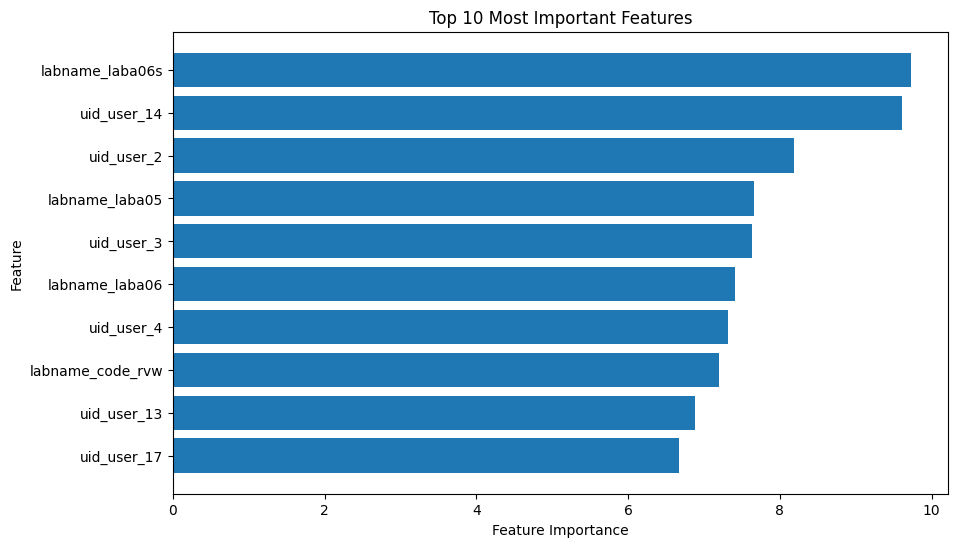

In [6]:
coef = np.sum(np.abs(model.coef_), axis=0)
plot_feature_importances(coef, X.columns)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [7]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernels:
    model = OneVsRestClassifier(SVC(kernel=kernel, probability=True, random_state=21))
    model.fit(X, y)
    accuracy = accuracy_score(y, model.predict(X))
    print(f'Accuracy with {kernel} kernel: {accuracy:.4f}')

Accuracy with linear kernel: 0.6738
Accuracy with poly kernel: 0.9330
Accuracy with rbf kernel: 0.9087
Accuracy with sigmoid kernel: 0.3493


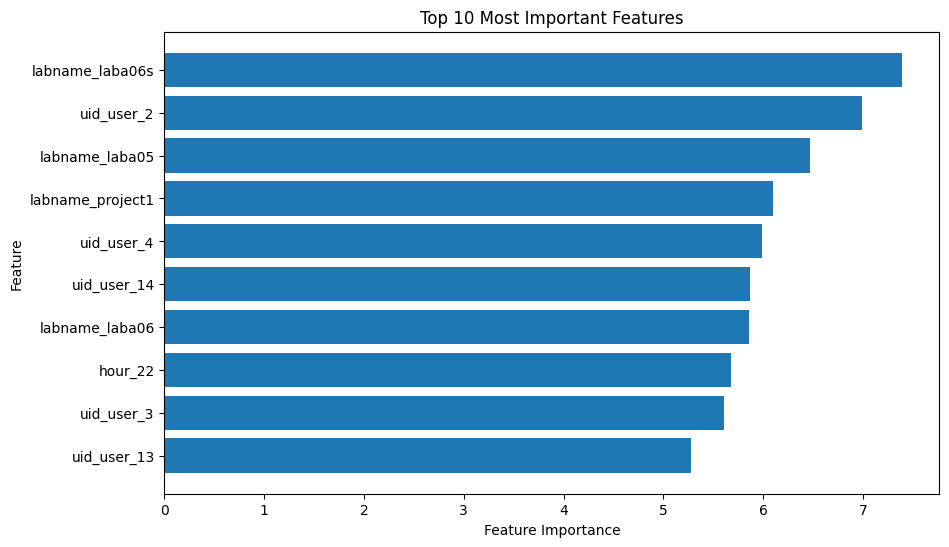

In [8]:
model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=21))
model.fit(X, y)

coef = np.sum([np.abs(est.coef_) for est in model.estimators_], axis=0)
plot_feature_importances(coef[0], X.columns)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [9]:
depths = [2, 4, 6, 8, 10]
for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=21)
    model.fit(X, y)
    accuracy = accuracy_score(y, model.predict(X))
    print(f'Accuracy with max_depth = {depth}: {accuracy:.4f}')

Accuracy with max_depth = 2: 0.4389
Accuracy with max_depth = 4: 0.5540
Accuracy with max_depth = 6: 0.6637
Accuracy with max_depth = 8: 0.7337
Accuracy with max_depth = 10: 0.8072


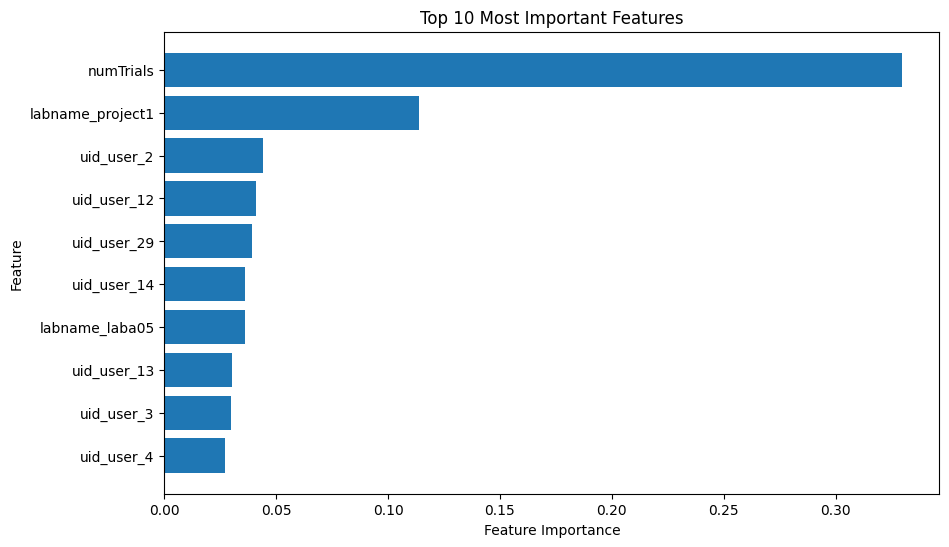

In [10]:
plot_feature_importances(np.abs(model.feature_importances_), X.columns)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [11]:
model = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
model.fit(X, y)

accuracy = accuracy_score(y, model.predict(X))
print(f'Accuracy with n_estimators = 100, max_depth = 25: {accuracy:.4f}')

Accuracy with n_estimators = 100, max_depth = 25: 0.9982


In [12]:
depths = [10, 20, 30, 40, 50]
estimators = [50, 100, 150, 200]
for depth in depths:
    for n_estimators in estimators:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=21)
        model.fit(X, y)
        accuracy = accuracy_score(y, model.predict(X))
        print(f'Accuracy with n_estimators = {n_estimators}, max_depth = {depth}: {accuracy:.4f}')

Accuracy with n_estimators = 50, max_depth = 10: 0.8126
Accuracy with n_estimators = 100, max_depth = 10: 0.8327
Accuracy with n_estimators = 150, max_depth = 10: 0.8357
Accuracy with n_estimators = 200, max_depth = 10: 0.8422
Accuracy with n_estimators = 50, max_depth = 20: 0.9887
Accuracy with n_estimators = 100, max_depth = 20: 0.9881
Accuracy with n_estimators = 150, max_depth = 20: 0.9887
Accuracy with n_estimators = 200, max_depth = 20: 0.9881
Accuracy with n_estimators = 50, max_depth = 30: 1.0000
Accuracy with n_estimators = 100, max_depth = 30: 1.0000
Accuracy with n_estimators = 150, max_depth = 30: 1.0000
Accuracy with n_estimators = 200, max_depth = 30: 1.0000
Accuracy with n_estimators = 50, max_depth = 40: 1.0000
Accuracy with n_estimators = 100, max_depth = 40: 1.0000
Accuracy with n_estimators = 150, max_depth = 40: 1.0000
Accuracy with n_estimators = 200, max_depth = 40: 1.0000
Accuracy with n_estimators = 50, max_depth = 50: 1.0000
Accuracy with n_estimators = 100, ma

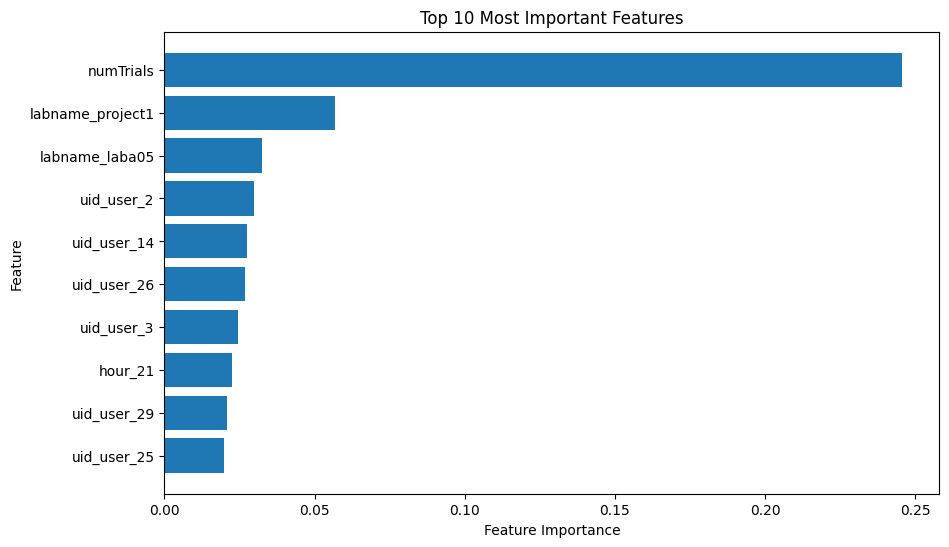

In [13]:
model = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
model.fit(X, y)

plot_feature_importances(model.feature_importances_, X.columns)